# Counter-Strike: Global Offensive Data Analysis

# Setup

In [1]:
# import the necessary packages for analysis
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#set the default figure size for seaborn charts
sns.set(rc = {'figure.figsize':(12, 8)})

#### Data has been previously cleaned.

In [2]:
# read in the master_dmg files and concatenate into a single df
dmg_df = pd.concat([pd.read_csv("csgo/cleaned/dmg_demos.part1.csv"),
                   pd.read_csv("csgo/cleaned/dmg_demos.part2.csv")],
                   ignore_index = True)

# read in the master meta files and concatenate into a single df
meta_df = pd.concat([pd.read_csv("csgo/cleaned/meta_demos.part1.csv"),
                   pd.read_csv("csgo/cleaned/meta_demos.part2.csv")],
                   ignore_index = True)

In [3]:
# remove the extraneous unnamed column from both dfs resulting from previous step
dmg_df = dmg_df.drop(['Unnamed: 0'],
                     axis = 1)

meta_df = meta_df.drop(['Unnamed: 0'],
                       axis = 1)

In [4]:
# show the first few rows of the dmg_df dataframe
dmg_df.head()

,file,round,att_side,vic_side,hp_dmg,is_bomb_planted,bomb_site,hitbox,wp,wp_type
0,esea_match_13770997.dem,1,CounterTerrorist,Terrorist,18,False,NaN,Stomach,USP,Pistol
1,esea_match_13770997.dem,1,CounterTerrorist,Terrorist,100,False,NaN,Head,USP,Pistol
2,esea_match_13770997.dem,1,Terrorist,CounterTerrorist,12,False,NaN,RightArm,Glock,Pistol
3,esea_match_13770997.dem,1,CounterTerrorist,Terrorist,15,False,NaN,Chest,USP,Pistol
4,esea_match_13770997.dem,1,Terrorist,CounterTerrorist,94,False,NaN,Head,Glock,Pistol


In [5]:
# show the first few rows of the dmg_df dataframe
meta_df.head()

,file,map,round,winner_side,round_type,ct_eq_val,t_eq_val
0,esea_match_13770997.dem,de_overpass,1,Terrorist,PISTOL_ROUND,4300,4250
1,esea_match_13770997.dem,de_overpass,2,Terrorist,ECO,6300,19400
2,esea_match_13770997.dem,de_overpass,3,Terrorist,SEMI_ECO,7650,19250
3,esea_match_13770997.dem,de_overpass,4,Terrorist,NORMAL,24900,23400
4,esea_match_13770997.dem,de_overpass,5,CounterTerrorist,ECO,5400,20550


# Research Question 1
#### What is the effect of the map choice on the outcome of a round of CS:GO?
#### H0: The proportion of rounds won per team per map is equal to 0.5.
#### HA: The proportion of rounds won per team per map is not equal to 0.5.

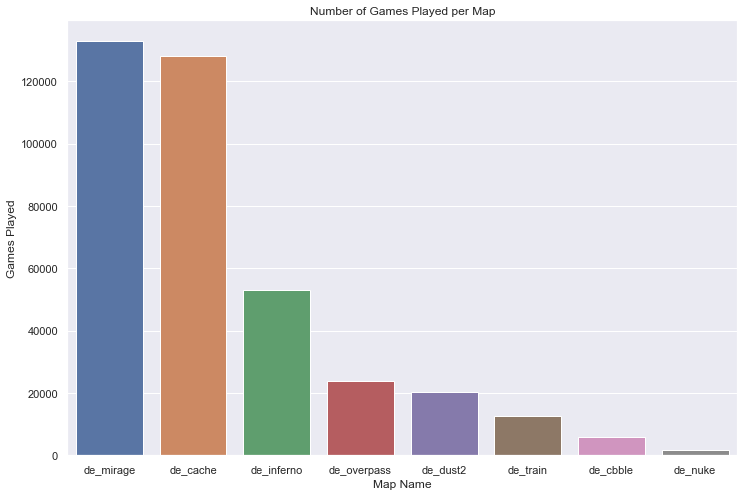

In [6]:
# create a plot showing how many times each map has been played
sns.countplot(x = 'map',
              data = meta_df,
              order = meta_df['map'].value_counts().index).set(xlabel = 'Map Name',
                                                              ylabel = 'Games Played',
                                                              title = 'Number of Games Played per Map')
plt.show()

In [7]:
# create a new dataframe showing the number of each teams' wins and the total rounds played per map
rq1_df = meta_df[['map', 'winner_side']].value_counts()
rq1_df = rq1_df.reset_index()
rq1_df.columns = ['map', 'winner_side', 'count']

rq1_df = rq1_df.pivot(index = 'map',
                      columns = 'winner_side',
                      values = 'count').reset_index()

# add a total column containing the total rounds per map
rq1_df['total'] = rq1_df['CounterTerrorist'] + rq1_df['Terrorist']
rq1_df

winner_side,map,CounterTerrorist,Terrorist,total
0,de_cache,60817,67207,128024
1,de_cbble,2746,3046,5792
2,de_dust2,9335,10890,20225
3,de_inferno,25034,27842,52876
4,de_mirage,66373,66488,132861
5,de_nuke,862,687,1549
6,de_overpass,12136,11561,23697
7,de_train,6711,5893,12604


In [8]:
# create an empty dict to hold result data
res = {}

# for each of the maps, run a 1 proportion z-test to determine map balance
for index, row in rq1_df.iterrows():
    stat, pval = proportions_ztest(count = row['CounterTerrorist'],
                                   nobs = row['total'],
                                   value = .5,
                                   alternative = 'two-sided')

    # save results into the results dictionary
    res[row['map']] = {}
    res[row['map']]['Z-Score'] = round(stat, 5)
    res[row['map']]['P-Value'] = round(pval, 5)

# convert dictionary to dataframe and show results
res_df = pd.DataFrame.from_dict(res)
res_df

,de_cache,de_cbble,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train
Z-Score,-17.88121,-3.94721,-10.96664,-12.22872,-0.31550,4.47509,3.73636,7.30156
P-Value,0.00000,0.00008,0.00000,0.00000,0.75238,0.00001,0.00019,0.00000


# Research Question 2
#### What is the relationship between terrorists planting a bomb and the outcome of a round in CS:GO?
#### H0: The proportion of rounds won is equal whether the bomb is planted or not.
#### HA: The proportion of rounds won is not equal if the bomb has been planted.

In [9]:
# create a dataframe with bomb status for each round combination
temp = dmg_df.groupby(['file','round'])['is_bomb_planted'].max()

In [10]:
# merge (join) bomb data to meta dataframe
bomb_df = meta_df.merge(temp, on = ['file', 'round'], how = 'left')
bomb_df = bomb_df[['winner_side', 'is_bomb_planted']].value_counts()
bomb_df = bomb_df.reset_index()
bomb_df.columns = ['winner_side', 'is_bomb_planted', 'count']

bomb_df = bomb_df.pivot(index = 'is_bomb_planted',
                        columns = 'winner_side',
                        values = 'count').reset_index()

# add a total column for the total number of rounds played
bomb_df['total'] = bomb_df['CounterTerrorist'] + bomb_df['Terrorist']
bomb_df

winner_side,is_bomb_planted,CounterTerrorist,Terrorist,total
0,False,142823,58179,201002
1,True,41191,135435,176626


In [11]:
# test if proportion of terrorist wins is equal whether bomb is placed or not
stat, pval = proportions_ztest(count = bomb_df['Terrorist'],
                               nobs = bomb_df['total'],
                               alternative = 'two-sided')

print('Z-Score: {0}, P-Value: {1}'.format(round(stat, 5), round(pval, 5)))

Z-Score: -292.81816, P-Value: 0.0


# Research Question 3
#### What is the relationship between the location of a hit and the damage done in CS:GO?
#### H0: Average damage is equal regardless of  the location of the hit.
#### HA: Average damage is unequal depending on the location of the hit.

In [12]:
# create new dataframe with the damage done and the hitbox using only pistol damage
hitbox_df = dmg_df[dmg_df['wp_type'] == 'Pistol'][['hp_dmg', 'hitbox']]

hitbox_df = hitbox_df.drop(hitbox_df[hitbox_df['hitbox'] == 'Generic'].index)

hitbox_df.head()

,hp_dmg,hitbox
0,18,Stomach
1,100,Head
2,12,RightArm
3,15,Chest
4,94,Head


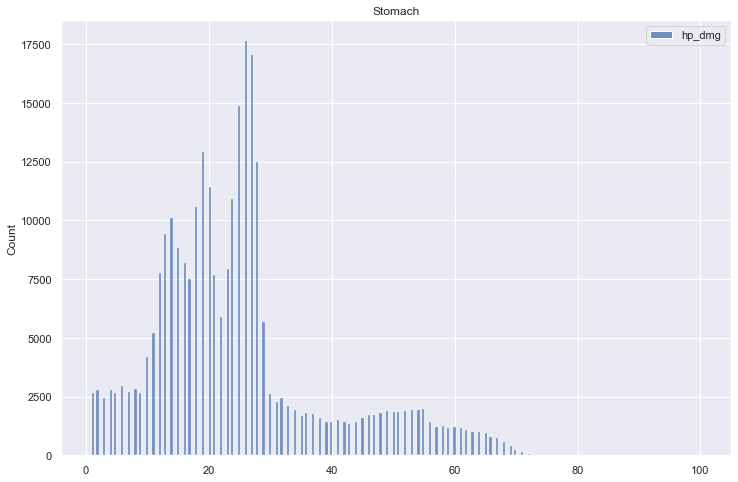

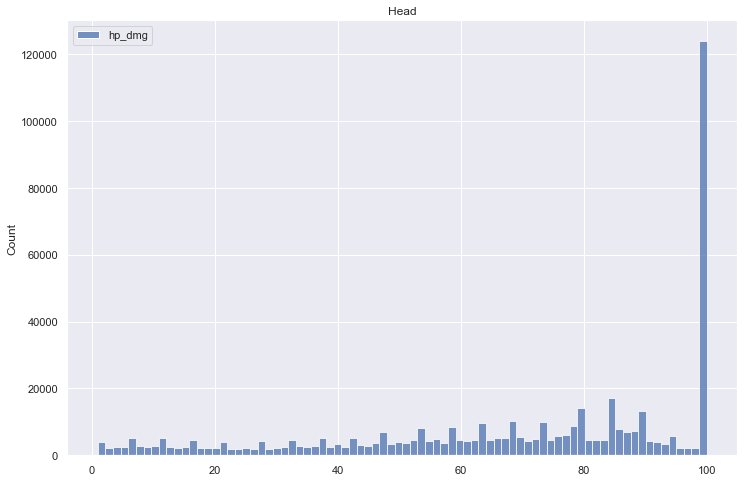

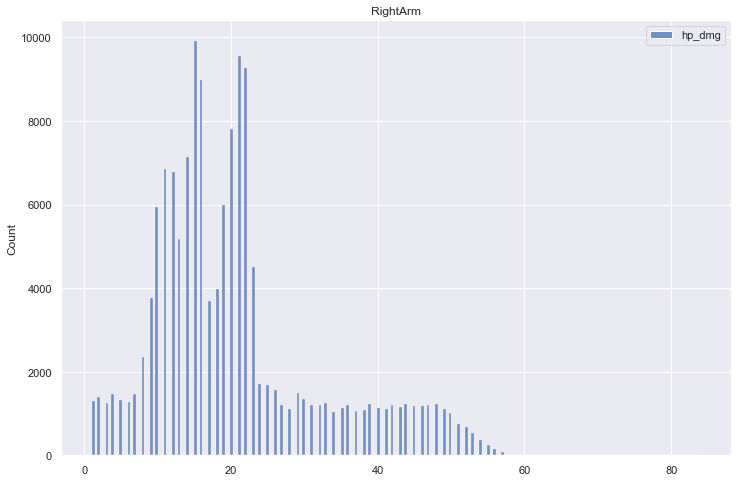

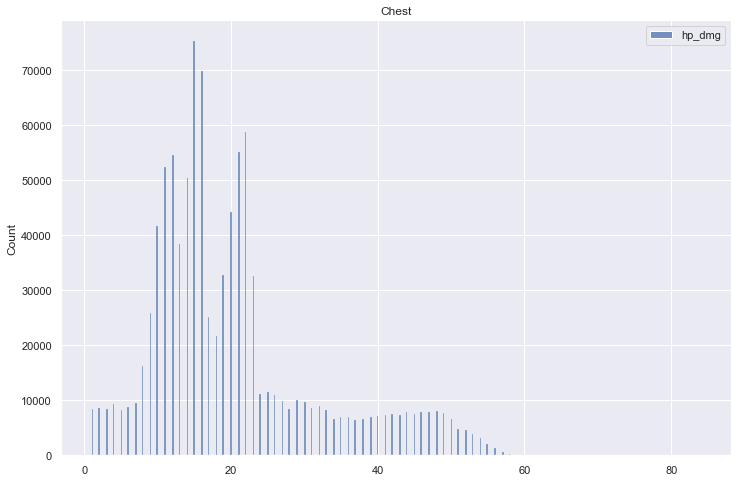

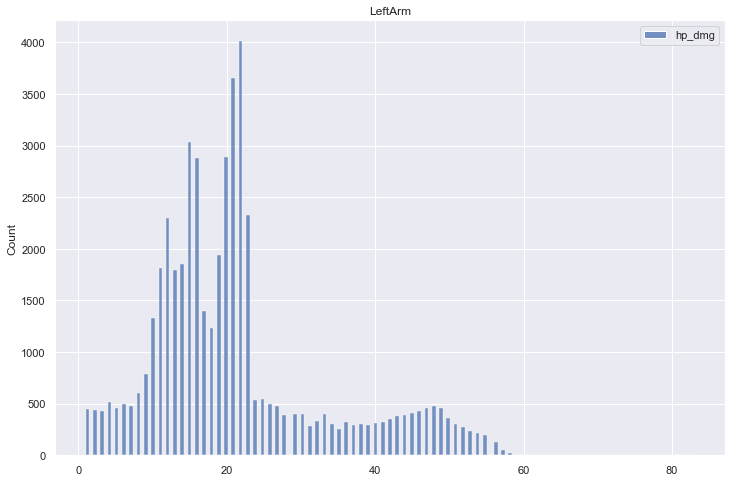

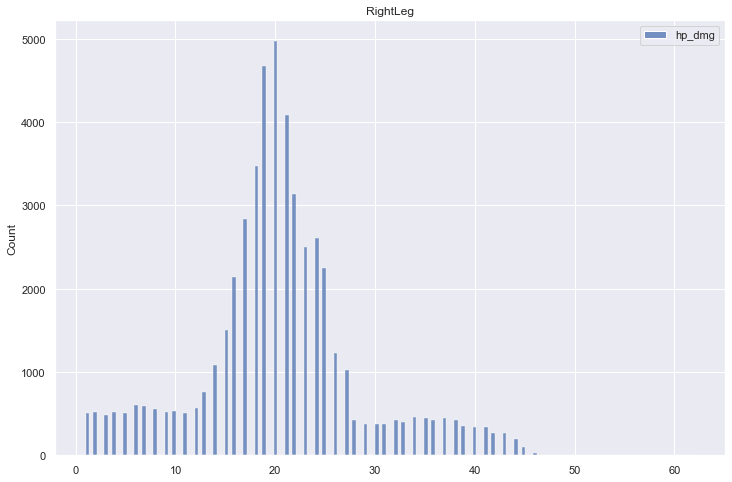

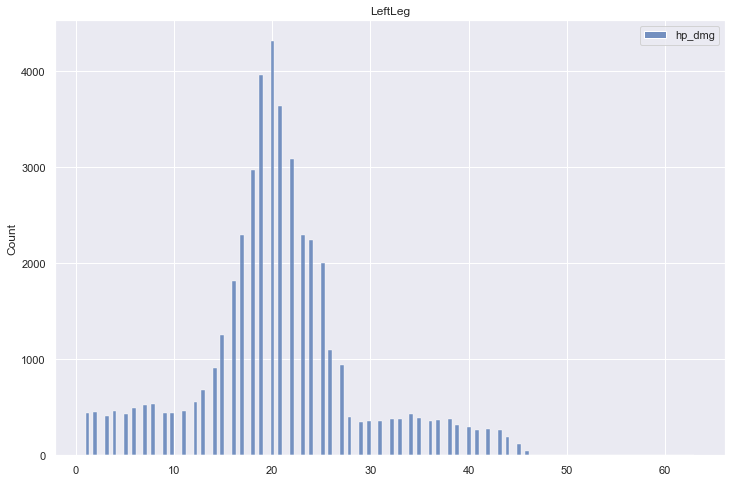

In [13]:
# create a histogram for each hitbox showing the damage done
for val in hitbox_df['hitbox'].unique():
    sns.histplot(data = hitbox_df[hitbox_df['hitbox'] == val]).set(title = val)
    plt.show()

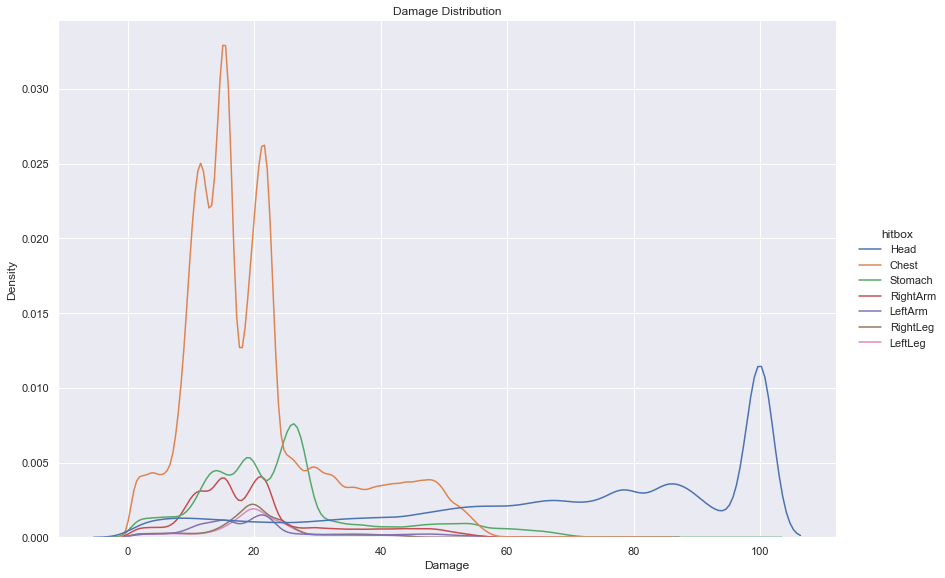

In [14]:
# create a kernel density estimation plot to show how distributions compare
sns.displot(data = hitbox_df,
            x = 'hp_dmg',
            hue = 'hitbox',
            height = 8,
            aspect = 1.5,
            kind = 'kde',
            hue_order = ['Head','Chest','Stomach','RightArm','LeftArm','RightLeg','LeftLeg']
           ).set(xlabel = 'Damage',
                 title = 'Damage Distribution')

plt.show()

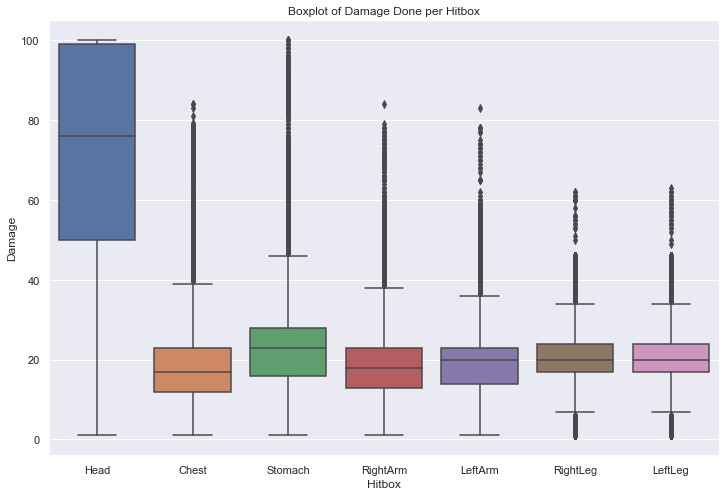

In [15]:
# create a  boxplot to show how distributions compare
sns.boxplot(data = hitbox_df,
            x = 'hitbox',
            y = 'hp_dmg',
            order = ['Head','Chest','Stomach','RightArm','LeftArm','RightLeg','LeftLeg']
           ).set(xlabel = 'Hitbox',
                 ylabel = 'Damage',
                 title = 'Boxplot of Damage Done per Hitbox')

plt.show()

In [16]:
# perform a one-way ANOVA test (robust to non-normality with large samples)
stat, pval = stats.f_oneway(hitbox_df[hitbox_df['hitbox'] == 'Stomach']['hp_dmg'],
                            hitbox_df[hitbox_df['hitbox'] == 'Head']['hp_dmg'],
                            hitbox_df[hitbox_df['hitbox'] == 'Chest']['hp_dmg'],
                            hitbox_df[hitbox_df['hitbox'] == 'RightArm']['hp_dmg'],
                            hitbox_df[hitbox_df['hitbox'] == 'LeftArm']['hp_dmg'],
                            hitbox_df[hitbox_df['hitbox'] == 'RightLeg']['hp_dmg'],
                            hitbox_df[hitbox_df['hitbox'] == 'LeftLeg']['hp_dmg'])

print('F-Value: {0}, P-Value: {1}'.format(round(stat, 5), round(pval, 5)))

F-Value: 456062.78434, P-Value: 0.0


In [17]:
# perform a pairwise tukey test to determine which means actually differ
res = pairwise_tukeyhsd(endog = hitbox_df['hp_dmg'],
                        groups = hitbox_df['hitbox'])

print(res)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
   Chest     Head  48.5355  0.001  48.4448  48.6263   True
   Chest  LeftArm   1.0153  0.001   0.7745   1.2562   True
   Chest  LeftLeg   0.2306 0.0951  -0.0201   0.4814  False
   Chest RightArm   0.2908  0.001   0.1455    0.436   True
   Chest RightLeg   0.0627    0.9  -0.1732   0.2986  False
   Chest  Stomach   4.6471  0.001   4.5361   4.7581   True
    Head  LeftArm -47.5202  0.001 -47.7669 -47.2736   True
    Head  LeftLeg -48.3049  0.001 -48.5612 -48.0486   True
    Head RightArm -48.2448  0.001 -48.3994 -48.0901   True
    Head RightLeg -48.4729  0.001 -48.7146 -48.2311   True
    Head  Stomach -43.8884  0.001 -44.0115 -43.7654   True
 LeftArm  LeftLeg  -0.7847  0.001  -1.1245  -0.4449   True
 LeftArm RightArm  -0.7245  0.001   -0.996  -0.4531   True
 LeftArm RightLeg  -0.9526  0.001  -1.2816  -0.6236   Tr

# Research Question 4
#### What is the effect of equipment value on whether a team wins a round in CS:GO?
#### H0: The team's equipment value is not correlated with more wins.
#### HA: The team's equipment value is correlated with more wins.

In [18]:
# create new dataframe with the equipment value and winning team
equip_df = meta_df[['winner_side', 'ct_eq_val', 't_eq_val']].reset_index()
equip_df = equip_df.drop(['index'], axis = 1)

# add a column that is the difference between counterterrorist and terrorist equipment value
equip_df['difference'] = equip_df['ct_eq_val'] - equip_df['t_eq_val']

# add a boolean for winner (required by test) 0: terrorist, 1: counterterrorist
equip_df['winner_bool'] = np.where(equip_df['winner_side'] == 'Terrorist', 0, 1)
    
equip_df.head()

,winner_side,ct_eq_val,t_eq_val,difference,winner_bool
0,Terrorist,4300,4250,50,0
1,Terrorist,6300,19400,-13100,0
2,Terrorist,7650,19250,-11600,0
3,Terrorist,24900,23400,1500,0
4,CounterTerrorist,5400,20550,-15150,1


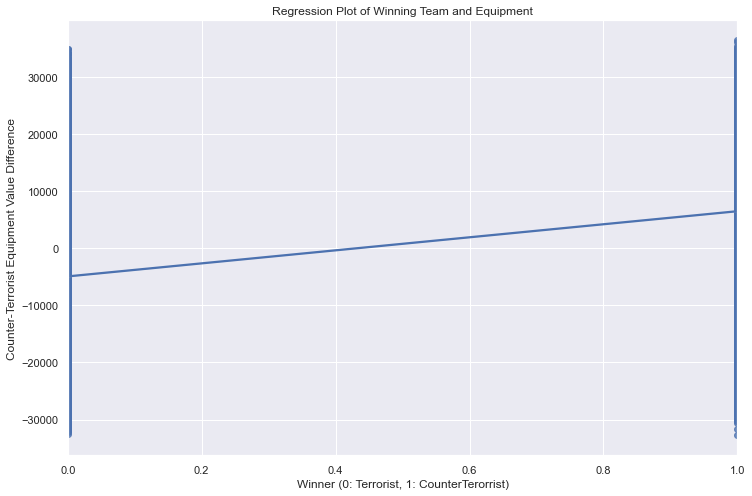

In [19]:
# create a plot to show how difference in equip value is related to the winning team
sns.regplot(data = equip_df,
               x = 'winner_bool',
               y = 'difference').set(xlabel = 'Winner (0: Terrorist, 1: CounterTerorrist)',
                                     ylabel = 'Counter-Terrorist Equipment Value Difference',
                                     title = 'Regression Plot of Winning Team and Equipment')

plt.show()

In [20]:
# perform a point biserial correlation analysis to determine the effect of equipment value on outcome
stat, pval = stats.pointbiserialr(equip_df['winner_bool'],
                    equip_df['difference'])

print('R: {0}, P-Value: {1}'.format(round(stat, 5), round(pval, 5)))

R: 0.41411, P-Value: 0.0
